### Lab_1

Для Домашней работы 1, колонки: `oaid_hash`, `banner_id0`, `banner_id1`, `rate0`, `rate1`, `g0`, `g1`, `coeff_sum0`, `coeff_sum1` использовать не нужно! Они будут использоваться в последующих Домашних работах.

- date_time - время показа рекламы
- zone_id - id зоны, где зона - место на сайте для размещения рекламы
- banner_id - id баннера, где баннер - сама реклама
- campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
- os_id - id операционной системы
- country_id - id страны
- impressions - был ли показ
- clicks - был ли клик

Task:
- Проанализируйте данные и подберите/сконструируйте осмысленные фичи.
- Постройте модель, которая предсказывает вероятность клика.
- Подберите для построенной модели регуляризацию. В качестве метрики считайте log-loss и auc.
- Свою итоговую модель примените к последнему дню датасета и вычислите log-loss и auc. Это будет неким ответом к домашней работе.
- Проверить, что ваше модель хорошая, нужно сравнив ее с бейзлайном (например, предикт среднего по выборке).
- Максимальный балл можно получить за использование не SGD-like оптимизатора. https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/#h-rprop-class


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

### Изначальные данные и работа с ними:

Так как некоторые features не нужно использовать в данной домашней работе - удалим их.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/RecSys/data.csv').drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1)
data.head()

In [ ]:
import matplotlib.pyplot as plt

Общее описание данных:
             zone_id     banner_id  campaign_clicks         os_id  \
count  1.582147e+07  1.582147e+07     1.582147e+07  1.582147e+07   
mean   8.152679e+01  3.816483e+02     6.238540e-01  1.840605e+00   
std    1.632448e+02  3.959386e+02     9.249152e+00  1.530005e+00   
min    0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%    1.400000e+01  5.200000e+01     0.000000e+00  1.000000e+00   
50%    1.900000e+01  2.170000e+02     0.000000e+00  2.000000e+00   
75%    6.000000e+01  6.110000e+02     0.000000e+00  3.000000e+00   
max    3.443000e+03  1.632000e+03     8.290000e+02  1.000000e+01   

         country_id  impressions        clicks  
count  1.582147e+07   15821472.0  1.582147e+07  
mean   4.346986e+00          1.0  2.668835e-02  
std    4.317701e+00          0.0  1.611710e-01  
min    0.000000e+00          1.0  0.000000e+00  
25%    0.000000e+00          1.0  0.000000e+00  
50%    4.000000e+00          1.0  0.000000e+00  
75%    7.000000e+00 

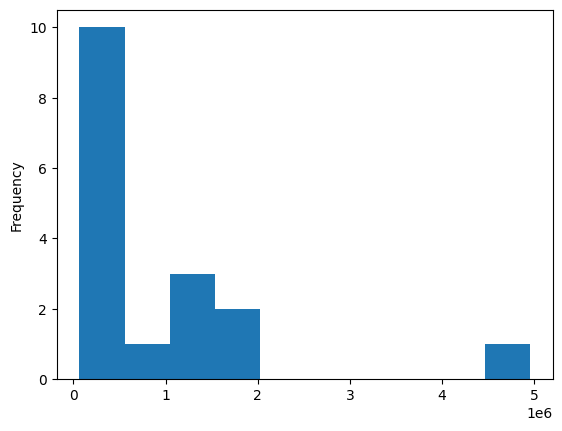

Диаграмма зависимости количество записей от страны:
 Axes(0.125,0.11;0.775x0.77) None 


Количество записей в зависимости от страны:
 0     4956393
5     1910054
6     1582705
7     1525569
1     1346321
3     1337392
15     603301
12     478038
9      439004
4      388801
10     356490
11     212245
8      210211
13     190855
14     138385
16      79166
2       66542
Name: country_id, dtype: int64 




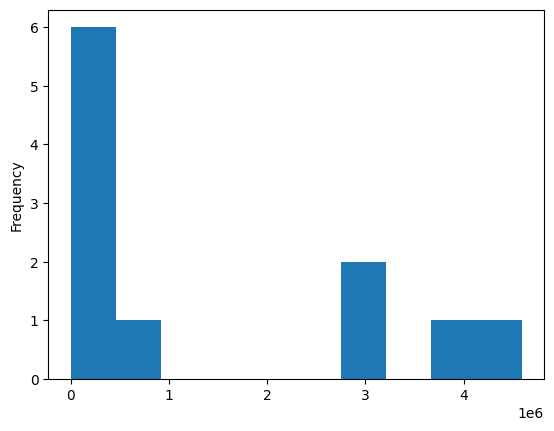

Диаграмма зависимости количество записей от ОС:
 Axes(0.125,0.11;0.775x0.77) None 




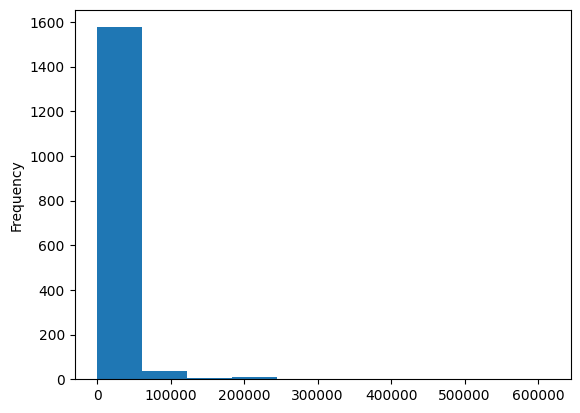

Частота встречающихся баннеров Axes(0.125,0.11;0.775x0.77) None 




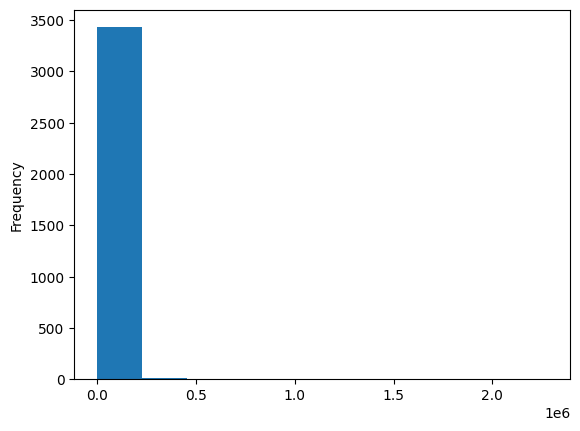

Частота используемых зон Axes(0.125,0.11;0.775x0.77) None 


Количество записей в зависимости от ОС:
 2     4589979
0     3856798
1     3178693
4     3012541
3      759767
6      310346
5      111946
8        1273
7          99
9          25
10          5
Name: os_id, dtype: int64 


Количество нулевых значений: 0
Дата c  2021-09-01 00:02:49.000000  до  2021-10-02 23:59:59.000000


In [ ]:
def analysis(data: pd.DataFrame):
    print('Общее описание данных:\n', data.describe(), '\n\n')
    print('Количество повторяющихся значений: ', len(data[data.duplicated()]), '\n\n')
    print('Диаграмма зависимости количество записей от страны:\n', data.country_id.value_counts().plot(kind='hist'), plt.show(), '\n\n')
    print('Количество записей в зависимости от страны:\n', data.country_id.value_counts(), '\n\n')
    print('Диаграмма зависимости количество записей от ОС:\n', data.os_id.value_counts().plot(kind='hist'), plt.show(),'\n\n')
    print('Частота встречающихся баннеров', data.banner_id.value_counts().plot(kind='hist'), plt.show(),'\n\n')
    print('Частота используемых зон', data.zone_id.value_counts().plot(kind='hist'), plt.show(),'\n\n')

    print('Количество записей в зависимости от ОС:\n', data.os_id.value_counts(), '\n\n')
    print('Количество нулевых значений:', data.isna().sum().sum())
    print('Дата c ', str(data.date_time.min()), ' до ', str(data.date_time.max()))
analysis(data)

### Поиск корреляции и фич

Работа была выполена в Колабе - и из-за большого количества данных у меня не получилось построить матрицу корреляции признаков для всех данных, поэтому мне пришлось выделить только 20% данных для построения.

In [ ]:
!pip install phik -q

import phik
from phik.report import plot_correlation_matrix
from phik import report
import matplotlib.pyplot as plt

In [ ]:
import copy

In [ ]:
y, X =  data['clicks'], data.drop(['clicks'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

interval columns not set, guessing: ['zone_id', 'banner_id', 'campaign_clicks', 'os_id', 'country_id', 'time', 'y']


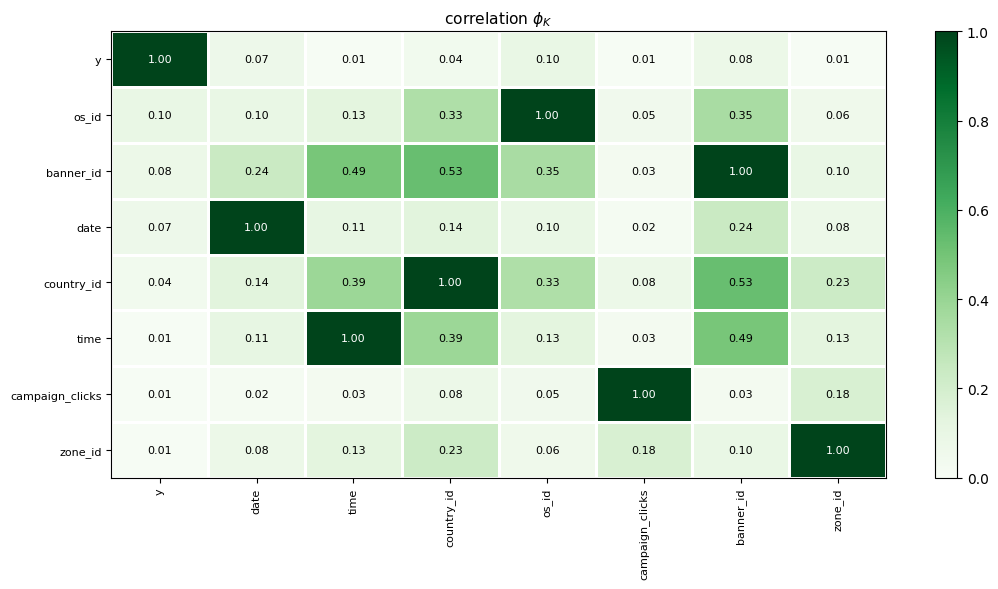

In [ ]:
phik_overview = X_train.phik_matrix().round(2).sort_values('y')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [ ]:
X_train['y'] = y_train

Признак `impressions` имеет константное значение - удалим его.
Разделим фичу с датой и временем на дату и время, так как от даты скорее всего зависимость меньше, чем от времени

Есть достаточно много повторяющихся данных (дубликатов) - удалим их тоже.

В столбце `zone_id` большинство значений меньше 3000, создадим для них отдельную группу.

In [ ]:
condition_zone_id = data['zone_id'].value_counts()
new_zone = condition_zone_id[condition_zone_id <= 3000]
new_zone.max()

2998

In [ ]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    data = data.drop(['impressions'], axis=1)
    data['hour'], data['month'], data['day'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.hour, \
                                              pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.month, \
                                              pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.day
    data = data.drop(['date_time'], axis=1)
    data.drop_duplicates(inplace=True)
    condition_zone_id = data['zone_id'].value_counts()
    new_zone = condition_zone_id[condition_zone_id <= 3000].index
    data['zone_id'] = data['zone_id'].apply(lambda x: 0 if x in new_zone else x)
    return data
data = feature_engineering(data)
data.tail()

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,hour,month,day
15821427,157,133,0,0,1,0,21,9,28
15821443,0,673,0,4,7,0,8,10,1
15821446,5,989,0,2,3,0,14,9,28
15821460,15,205,3,2,15,0,3,9,28
15821470,0,21,0,0,0,0,0,9,29


In [ ]:
data.to_csv('/content/drive/MyDrive/RecSys/data_preprocess_2.csv', index=False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/RecSys/data_preprocess_2.csv')
data.head()

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,hour,month,day
0,0,0,0,0,0,1,0,9,27
1,1,1,0,0,1,1,22,9,26
2,2,2,3,0,0,1,23,9,26
3,3,3,0,1,1,1,0,9,27
4,4,4,0,1,0,1,0,9,27


In [ ]:
baseline = data.clicks.value_counts()[1] / data.clicks.count() # средняя вероятность клика
baseline

0.06447902790030967

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

Accuracy: 0.9358
Log Loss: 0.2317
ROC AUC: 0.6374


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97    584021
           1       0.00      0.00      0.00     40080

    accuracy                           0.94    624101
   macro avg       0.47      0.50      0.48    624101
weighted avg       0.88      0.94      0.90    624101



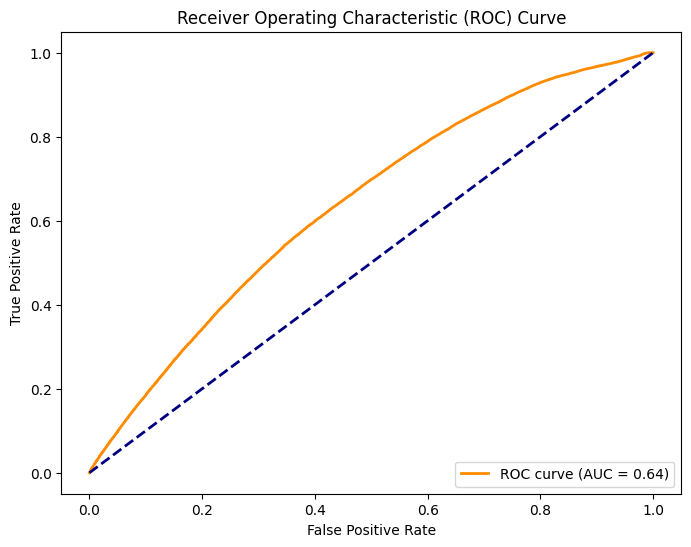

baseline 0.06447902790030967


In [ ]:
def create_model(data: pd.DataFrame):
    y, X =  data['clicks'], data.drop(['clicks'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(solver='liblinear', max_iter=2000, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_probab = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_probab)
    roc_auc = roc_auc_score(y_test, y_probab)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print("Classification Report:\n", classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_probab)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print('baseline', data.clicks.value_counts()[1] / data.clicks.count()) # средняя вероятность клика)
create_model(data)

In [ ]:
# ohe = OneHotEncoder(sparse=False)
#one_hot_os = pd.get_dummies(data['os_id'])
#one_hot_country = pd.get_dummies(data['country_id'])
#data = data.join(one_hot_country, one_hot_os)
# data = data.join(one_hot_os)
#data.drop(['os_id', 'country_id'], axis=1)

In [ ]:
def cv(data: pd.DataFrame):
    pass